<a href="https://colab.research.google.com/github/fionisarnen/Lifelong-Learning-churn-prediction-torch/blob/master/fix_LL_dynamic_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
''' Torch: A package containing data structures for multi-dimensional tensors and mathematical operations
    Torch.nn: Creating and training neural networks. The data inputted into these modules are passed in the form of Tensors.
    tqdm library use for progress bar per epoch looping
    
    EWC framework code reference : https://github.com/shivamsaboo17/Overcoming-Catastrophic-forgetting-in-Neural-Networks
    'Traditional' Sequence training on : https://colab.research.google.com/drive/1UY2vZ0Fj0yfMz7MrArED7_rsEvASt7kx?usp=sharing
'''

from __future__ import print_function, division
import torch
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torch.optim as optim
##
from google.colab import files
from tqdm import tqdm
from torch import autograd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.preprocessing import LabelEncoder

**Supported Library**

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [3]:
from google.colab import files
upload= files.upload()

Saving bigml_59c28831336c6604c800002a.csv to bigml_59c28831336c6604c800002a.csv
Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


# Datasets Preparations

What i do :
- pre processing
- create new csv file
easier to load with dataloader torch

Pre processing as follows

1. Drop Unique feature (task 1=customerId, task 2= phone number)
2. Convert categorial value
3. Convert pandas dataframe to numpy array then to tensors for pytorch

*we need to transformed dataset in csv into appropriately processed Tensors as a valid pytorch input


In [4]:
#TASK 1 as Old Task

data1 = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
data1.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [5]:
churn_yes = (data1['Churn'] == 'Yes').sum()
churn_no = (data1['Churn'] == 'No').sum()
labels = ['Churn Rate', 'Retention Rate']
values = [churn_yes, churn_no]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
fig.update_traces(textfont_size=18)
fig.update_layout(title='Churn Rate - Old Task',)

fig.show()

In [6]:
##PREPROCESSING
new = data1.columns.tolist()
le = LabelEncoder()
data1[new] = data1[new].apply(lambda col: le.fit_transform(col))
##
csv1 = data1[new].drop(['customerID'], axis = 1) 
csv1.to_csv('task1.csv', index=False)

#create path to load in dataset
preview1 = pd.read_csv('task1.csv')
preview1.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,142,2505,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,498,1466,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,436,157,1


In [7]:
#TASK 2 as New Task

data2 = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
data2.head(3)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False


In [8]:
churn_yes = (data2['churn'] == 1).sum()
churn_no = (data2['churn'] == 0).sum()

labels = ['Churn Rate', 'Retention Rate']
values = [churn_yes, churn_no]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
fig.update_traces(textfont_size=18)
fig.update_layout(title='Churn Rate - New Task',)

fig.show()

In [9]:
#Encode Categorical
new = data2.columns.tolist()
le = LabelEncoder()
data2[new] = data2[new].apply(lambda col: le.fit_transform(col))
##
csv2 = data2[new].drop(['phone number'], axis = 1) 
csv2.to_csv('task2.csv', index=False)
preview2 = pd.read_csv('task2.csv')
preview2.head(3)

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,16,126,1,0,1,19,1491,70,1491,767,60,684,1184,49,657,79,3,79,1,0
1,35,105,1,0,1,20,667,83,667,748,64,668,1265,61,701,116,3,116,1,0
2,31,135,1,0,0,0,1362,74,1362,158,71,150,443,62,292,101,5,101,0,0


# CSV to PyTorch Dataset
I reference the part to load custom dataset via Torch from: 
https://medium.com/@shashikachamod4u/excel-csv-to-pytorch-dataset-def496b6bcc1

In [10]:
class FeatureDataset(Dataset):
  def __init__(self,file_name):
    file_out = pd.read_csv(file_name)
    x = file_out.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]].values
    y = file_out.iloc[:,-1].values

    #convert to torch tensors
    self.data = torch.tensor(x,dtype=torch.float32)
    self.targets = torch.tensor(y)

  def __len__(self):
    return len(self.targets)

  def __getitem__(self,idx):
    return self.data[idx], self.targets[idx]


In [11]:
load_old_task = FeatureDataset('task1.csv')
train_loader = torch.utils.data.DataLoader(load_old_task, batch_size = 32, shuffle=True)
load_old_task.data.shape,load_old_task.targets.shape

(torch.Size([7043, 19]), torch.Size([7043]))

In [12]:
load_new_task = FeatureDataset('task2.csv')
test_loader = DataLoader(load_new_task, batch_size = 32, shuffle=True)
load_new_task.data.shape,load_new_task.targets.shape

(torch.Size([3333, 19]), torch.Size([3333]))

# Define Model 

In [13]:
#create function for each hidden layer with each act function
class LinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim, act='relu', use_bn=False):
        super(LinearLayer, self).__init__()
        self.use_bn = use_bn
        self.lin = nn.Linear(input_dim, output_dim)
        self.act = nn.ReLU() if act == 'relu' else act
        if use_bn:
            self.bn = nn.BatchNorm1d(output_dim)
    def forward(self, x):
        if self.use_bn:
            return self.bn(self.act(self.lin(x)))
        return self.act(self.lin(x))

class LinearLayer2(nn.Module):
    def __init__(self, input_dim, output_dim, act='sigmoid', use_bn=False):
        super(LinearLayer2, self).__init__()
        self.use_bn = use_bn
        self.lin = nn.Linear(input_dim, output_dim)
        self.act = nn.LogSigmoid() if act == 'sigmoid' else act
        if use_bn:
            self.bn = nn.BatchNorm1d(output_dim)
    def forward(self, x):
        if self.use_bn:
            return self.bn(self.act(self.lin(x)))
        return self.act(self.lin(x))

class Flatten(nn.Module):
    def forward(self, x):
        return x.data

In [14]:
#create model nn (all layers)

class BaseModel(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super(BaseModel, self).__init__()
        # Number of input features is 19.
        self.f1 = Flatten()
        self.layer_1 = LinearLayer(num_inputs, num_hidden) 
        self.layer_2 = LinearLayer2(num_hidden, num_hidden)
        self.layer_out = nn.Linear(num_hidden, num_outputs) 

    def forward(self, x):
        x = self.layer_out(self.layer_2(self.layer_1(self.f1(x))))
        return x 

In [15]:
def accu(model, dataloader):
        model = model.eval()
        acc = 0
        for input, target in dataloader:
      
            ewc.forward_backward_update(input,target)   #nn backpropagation
            
            pred = model(input)
            acc += (pred.argmax(dim=1).long() == target).float().mean()
            
        return acc / len(dataloader)

In [16]:
def losses(model,dataloader):
  for input,target in dataloader:
    output = model(input)
    loss = crit(output,target)
    return loss

# EWC Framework

In [17]:
class ElasticWeightConsolidation:
    #1
    def __init__(self, model, crit, lr=0.001, weight=1000000):
        self.model = model
        self.weight = weight
        self.crit = crit
        self.optimizer = optim.Adam(self.model.parameters(), lr)

    #2
    def forward_backward_update(self, input, target):
        output = self.model(input)
        loss = self._compute_consolidation_loss(self.weight) + self.crit(output, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss

    #3
    def _compute_consolidation_loss(self, weight):
        try:
            losses = []
            for param_name, param in self.model.named_parameters():
                _buff_param_name = param_name.replace('.', '__')
                estimated_mean = getattr(self.model, '{}_estimated_mean'.format(_buff_param_name))
                estimated_fisher = getattr(self.model, '{}_estimated_fisher'.format(_buff_param_name))
                losses.append((estimated_fisher * (param - estimated_mean) ** 2).sum())
                loss_ewc = (weight / 2) * sum(losses)
            return loss_ewc
        except AttributeError:
            return 0

    #4
    def register_ewc_params(self, dataset, batch_size, num_batches):
        self._update_fisher_params(dataset, batch_size, num_batches)
        self._update_mean_params()

    #5
    def _update_mean_params(self):
        for param_name, param in self.model.named_parameters():
            _buff_param_name = param_name.replace('.', '__')
            self.model.register_buffer(_buff_param_name+'_estimated_mean', param.data.clone())

    #6
    def _update_fisher_params(self, current_ds, batch_size, num_batch):
        dl = DataLoader(current_ds, batch_size, shuffle=True)
        log_liklihoods = []
        for i, (input, target) in enumerate(dl):
            if i > num_batch:
                break
            targets = target.type(torch.LongTensor)
            output = F.sigmoid(self.model(input))
            log_liklihoods.append(output[:, targets])
        log_likelihood = torch.cat(log_liklihoods).mean()
        grad_log_liklihood = autograd.grad(log_likelihood, self.model.parameters())
        _buff_param_names = [param[0].replace('.', '__') for param in self.model.named_parameters()]
        for _buff_param_name, param in zip(_buff_param_names, grad_log_liklihood):
            self.model.register_buffer(_buff_param_name+'_estimated_fisher', param.data.clone() ** 2)

    #7
    def save(self, filename):
        torch.save(self.model, filename)

    #8
    def load(self, filename):
        self.model = torch.load(filename)


# Training

How to use
1. Fit 2 layer NN model (BaseModel) in EWC framework that consist of multiple ewc def 
*   normal forward&backward
*   compute consolidation loss
*   compute fisher params
*   save and load previous model for train on new task

2. Train first model on old task (yang akan menyimpan model untuk melatih new task)
3. Train model untuk task2 selanjutnya secara berurutan



In [18]:
crit = nn.CrossEntropyLoss()
ewc = ElasticWeightConsolidation(BaseModel(19,100,2), crit=crit, lr=1e-4)

In [19]:
EPOCHS = 50
count = 0
loss_list = []
epoch_list = []
accuracy_list = []

for e in range(1, EPOCHS+1):
    count += 1
    epoch_acc = 0 
    acc = accu(ewc.model, train_loader)
    loss = losses(ewc.model,train_loader)
    ###store acc and loss value to a list
    accuracy_list.append(acc)
    loss_list.append(loss)
    epoch_list.append(count)

    print(f'Epoch {e+0:02}: |  Acc: {acc:.4f} | Loss: {loss:.4f} ')

Epoch 01: |  Acc: 0.7267 | Loss: 0.3955 
Epoch 02: |  Acc: 0.7450 | Loss: 0.4784 
Epoch 03: |  Acc: 0.7428 | Loss: 3.1505 
Epoch 04: |  Acc: 0.7493 | Loss: 0.7259 
Epoch 05: |  Acc: 0.7602 | Loss: 0.4196 
Epoch 06: |  Acc: 0.7684 | Loss: 0.3265 
Epoch 07: |  Acc: 0.7551 | Loss: 0.8890 
Epoch 08: |  Acc: 0.7587 | Loss: 0.4525 
Epoch 09: |  Acc: 0.7626 | Loss: 0.4414 
Epoch 10: |  Acc: 0.7694 | Loss: 0.3608 
Epoch 11: |  Acc: 0.7592 | Loss: 0.3045 
Epoch 12: |  Acc: 0.7709 | Loss: 1.0414 
Epoch 13: |  Acc: 0.7479 | Loss: 1.3133 
Epoch 14: |  Acc: 0.7646 | Loss: 0.4712 
Epoch 15: |  Acc: 0.7753 | Loss: 0.4014 
Epoch 16: |  Acc: 0.7529 | Loss: 0.6717 
Epoch 17: |  Acc: 0.7715 | Loss: 0.8451 
Epoch 18: |  Acc: 0.7716 | Loss: 0.5679 
Epoch 19: |  Acc: 0.7687 | Loss: 0.3309 
Epoch 20: |  Acc: 0.7612 | Loss: 0.9482 
Epoch 21: |  Acc: 0.7636 | Loss: 0.7822 
Epoch 22: |  Acc: 0.7603 | Loss: 0.5714 
Epoch 23: |  Acc: 0.7709 | Loss: 0.9152 
Epoch 24: |  Acc: 0.7641 | Loss: 0.3645 
Epoch 25: |  Acc

**---The key of EWC training (to be able training on new task with previous knowledge collected on first task) is this part **

In [20]:
ewc.register_ewc_params(load_old_task, 32, 100)

*Train on new task*

In [21]:
EPOCHS = 50
count = 0
loss_list2 = []
epoch_list = []
accuracy_list2 = []

for e in range(1, EPOCHS+1):

    count += 1
    epoch_acc = 0 
    acc = accu(ewc.model, test_loader)
    loss = losses(ewc.model,test_loader)   
    ###store acc and loss value to a list
    accuracy_list2.append(acc)
    epoch_list.append(count)
    loss_list2.append(loss)

    print(f'Epoch {e+0:02}: |  Acc: {acc:.4f} | Loss: {loss:.4f} ')

Epoch 01: |  Acc: 0.7842 | Loss: 2.6739 
Epoch 02: |  Acc: 0.7690 | Loss: 1.0575 
Epoch 03: |  Acc: 0.7798 | Loss: 0.5336 
Epoch 04: |  Acc: 0.7882 | Loss: 1.0419 
Epoch 05: |  Acc: 0.7966 | Loss: 0.8664 
Epoch 06: |  Acc: 0.7996 | Loss: 0.4781 
Epoch 07: |  Acc: 0.8061 | Loss: 0.4594 
Epoch 08: |  Acc: 0.8058 | Loss: 0.5813 
Epoch 09: |  Acc: 0.8105 | Loss: 0.5980 
Epoch 10: |  Acc: 0.8199 | Loss: 0.6575 
Epoch 11: |  Acc: 0.8179 | Loss: 0.4287 
Epoch 12: |  Acc: 0.8369 | Loss: 0.4503 
Epoch 13: |  Acc: 0.8304 | Loss: 0.7079 
Epoch 14: |  Acc: 0.8357 | Loss: 0.1494 
Epoch 15: |  Acc: 0.8333 | Loss: 0.3473 
Epoch 16: |  Acc: 0.8305 | Loss: 0.2685 
Epoch 17: |  Acc: 0.8243 | Loss: 0.3954 
Epoch 18: |  Acc: 0.8357 | Loss: 0.4118 
Epoch 19: |  Acc: 0.8398 | Loss: 0.3105 
Epoch 20: |  Acc: 0.8417 | Loss: 0.9350 
Epoch 21: |  Acc: 0.8357 | Loss: 0.4296 
Epoch 22: |  Acc: 0.8443 | Loss: 0.2087 
Epoch 23: |  Acc: 0.8350 | Loss: 0.3482 
Epoch 24: |  Acc: 0.8530 | Loss: 0.4384 
Epoch 25: |  Acc

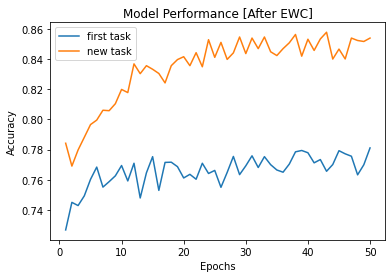

In [22]:
plt.plot(epoch_list,accuracy_list)
plt.plot(epoch_list,accuracy_list2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['first task','new task'], loc='bottom left')
plt.title("Model Performance [After EWC]")
plt.savefig('myimage.png', format='png', dpi=1200)

In [23]:
saved = plt.figure()
saved.savefig('destination_path.eps', format='eps', dpi=1000)
#plt.savefig('myimage.svg', format='svg', dpi=1200)

<Figure size 432x288 with 0 Axes>

*Summary of the network*

In [24]:
print(ewc.model)

BaseModel(
  (f1): Flatten()
  (layer_1): LinearLayer(
    (lin): Linear(in_features=19, out_features=100, bias=True)
    (act): ReLU()
  )
  (layer_2): LinearLayer2(
    (lin): Linear(in_features=100, out_features=100, bias=True)
    (act): LogSigmoid()
  )
  (layer_out): Linear(in_features=100, out_features=2, bias=True)
)
